# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
data = pd.read_csv('train.csv')
data

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
data.drop(columns='dropoff_datetime', inplace = True)

In [5]:
from datetime import datetime

In [6]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

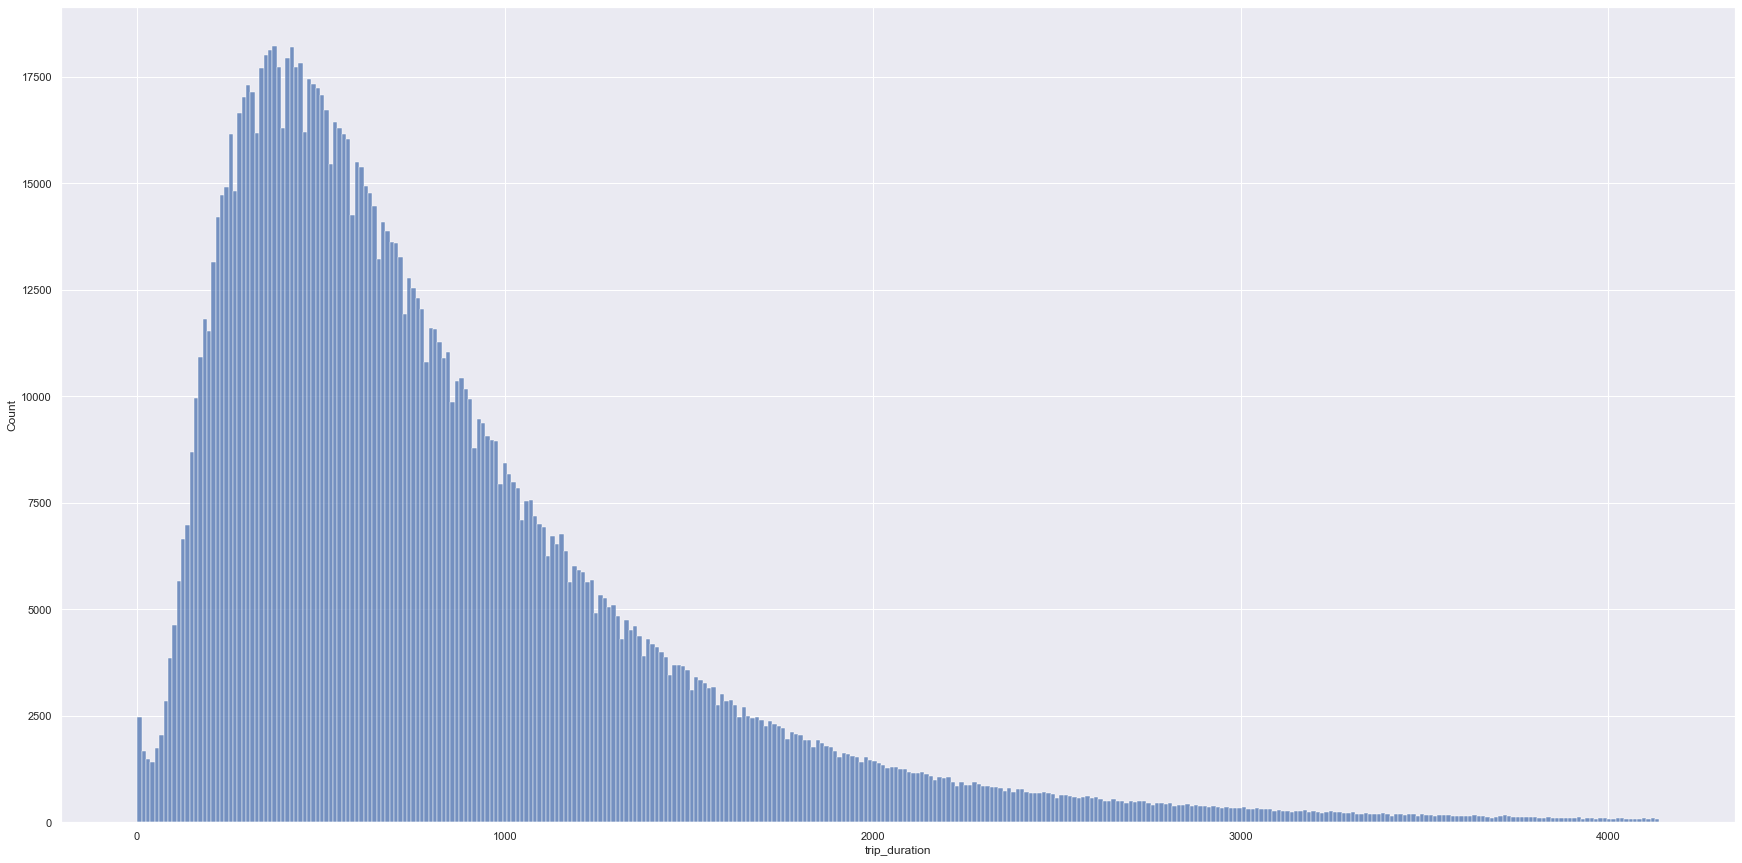

In [7]:
plt.figure(figsize=(30,15))
sns.histplot(data["trip_duration"][data["trip_duration"] < np.quantile(data["trip_duration"], 0.995)])
plt.show()

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$


На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [8]:
data['log_trip_duration'] = np.log1p(data['trip_duration'])

In [9]:
data.drop(columns='trip_duration', inplace= True)

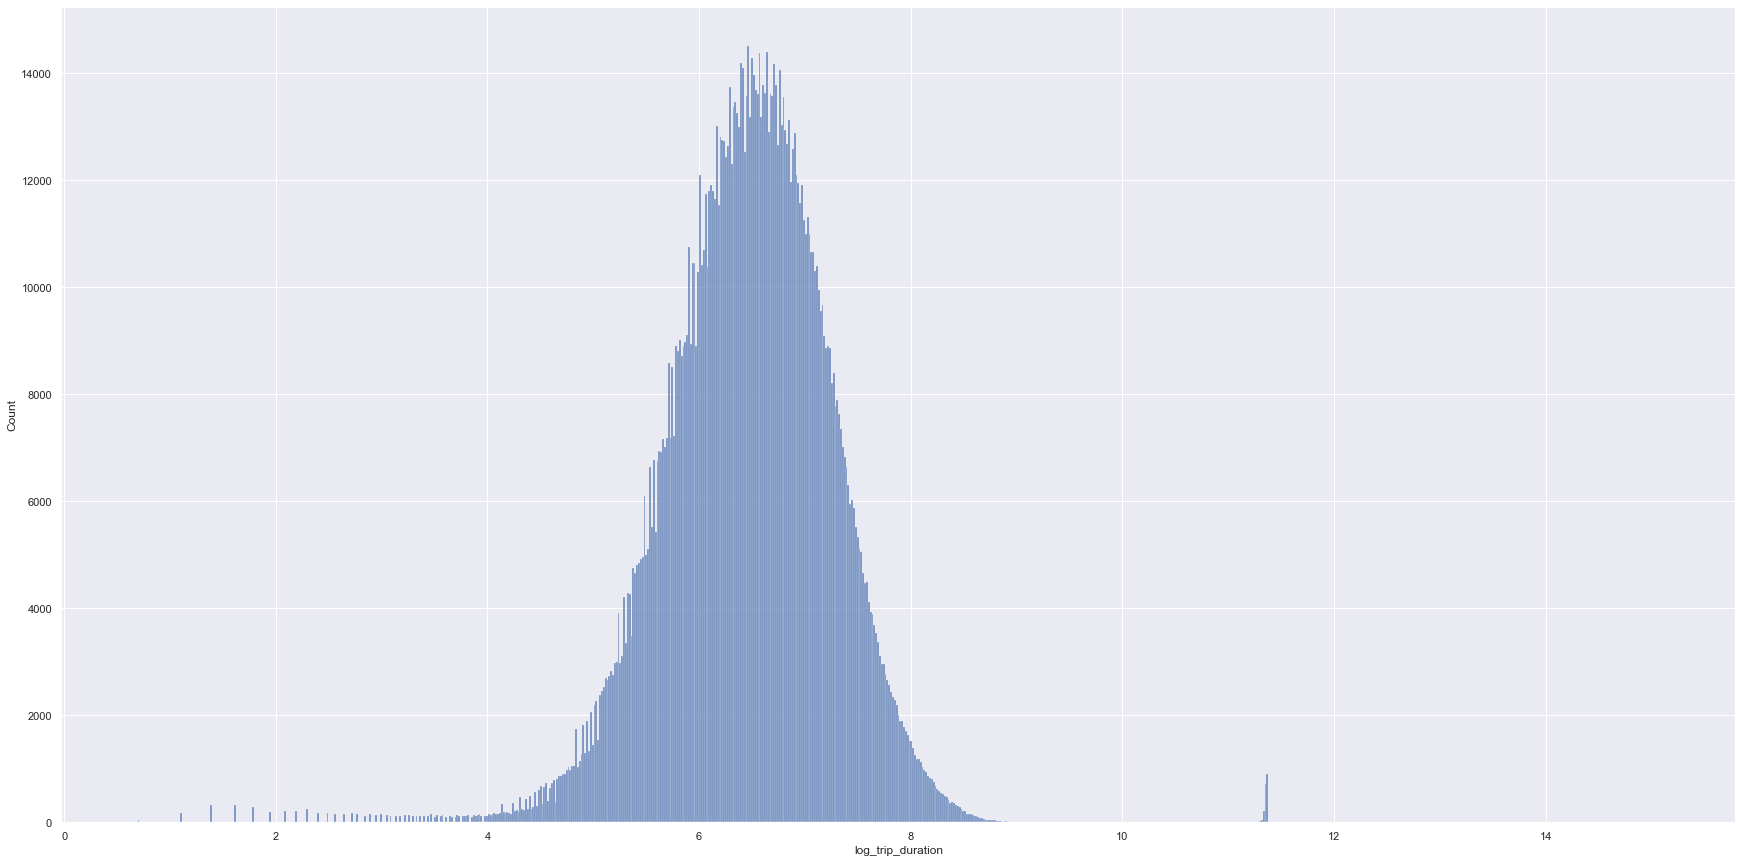

In [10]:
plt.figure(figsize=(30,15))
sns.histplot(data["log_trip_duration"])
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [11]:
from sklearn.metrics import mean_squared_error
mean_squared_error(data["log_trip_duration"], np.ones(data.shape[0]) * np.mean(data["log_trip_duration"]), squared=False)

0.7957592365411504

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [12]:
data['pickup_date'] = data['pickup_datetime'].apply(datetime.date)

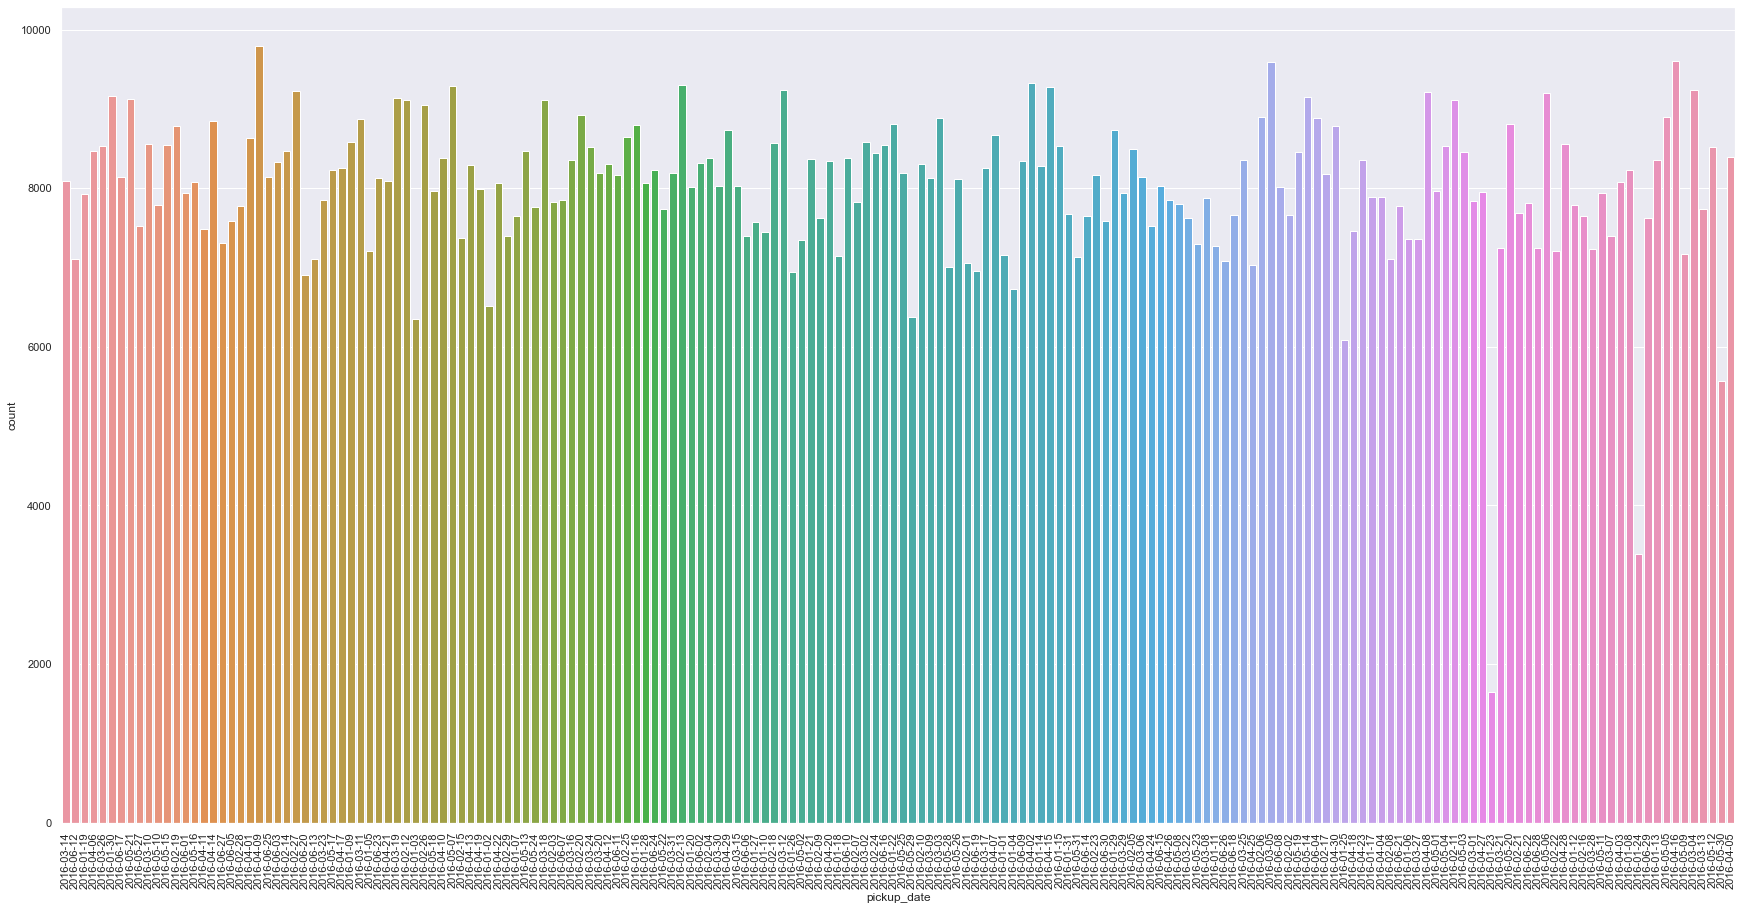

In [13]:
plt.figure(figsize=(30,15))
sns.countplot(x='pickup_date', data=data)
plt.xticks(rotation=90)
plt.show()

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [14]:
data.groupby('pickup_date').count()['id'].sort_values()[0:2]

pickup_date
2016-01-23    1648
2016-01-24    3383
Name: id, dtype: int64

In [15]:
data.groupby('pickup_date').count()['id'].values

array([7162, 6512, 6353, 6725, 7204, 7365, 7649, 8229, 8578, 7454, 7276,
       7794, 8360, 8277, 8539, 8797, 7891, 7146, 7934, 8018, 8375, 8805,
       1648, 3383, 6084, 6941, 7571, 8066, 8735, 9166, 7670, 7064, 7668,
       7828, 8377, 8501, 8904, 7821, 7110, 7620, 8311, 9116, 9108, 9309,
       8473, 7373, 7646, 8181, 8572, 8781, 8922, 7683, 7209, 8172, 8442,
       8642, 9056, 9232, 7777, 7402, 7839, 8578, 8888, 9237, 9597, 8138,
       7395, 7879, 8127, 8557, 8880, 9241, 7738, 8091, 8032, 8361, 8259,
       9115, 9143, 8199, 7248, 7622, 7852, 8527, 8353, 8535, 7364, 7233,
       7943, 8031, 8187, 8640, 9325, 8084, 7891, 8389, 8468, 8669, 9215,
       9796, 8379, 7485, 8301, 8296, 8846, 9276, 9602, 8254, 7459, 7990,
       8341, 8091, 8062, 8352, 7529, 7028, 7858, 7949, 8558, 8732, 8780,
       7964, 7344, 8457, 8535, 8896, 9202, 9285, 7801, 7174, 7789, 7941,
       8524, 8476, 9147, 8547, 8077, 8237, 7971, 8455, 8808, 9127, 7745,
       7300, 7762, 8195, 8121, 7530, 7004, 6372, 55

In [16]:
data['weekday'] = data['pickup_date'].apply(datetime.weekday)

In [17]:
data['hour'] = data['pickup_datetime'].apply(lambda x: x.hour)

In [18]:
data[data['weekday'] == 0].groupby('hour').count()['id']

hour
0      4299
1      2578
2      1658
3      1226
4      1351
5      2147
6      5357
7      8620
8     10342
9     10007
10     8625
11     8783
12     9130
13     9117
14     9910
15     9959
16     9160
17    10857
18    12959
19    12234
20    11334
21    11192
22     9608
23     6965
Name: id, dtype: int64

In [19]:
data['count_hour'] = 1
for j in range(7):
    c = data[data['weekday'] == j].groupby('hour').count()['id']
    for i in range(24):
        data.loc[data[data['hour'] == i][data['weekday'] == j].index, 'count_hour'] = c[i]

C:\Users\solmi\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<Figure size 2160x1080 with 0 Axes>

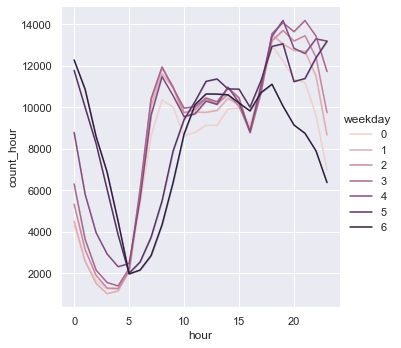

In [20]:
plt.figure(figsize=(30,15))
sns.relplot(data=data, x='hour', y='count_hour', hue='weekday', kind="line")
plt.show()

In [21]:
data

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,pickup_date,weekday,hour,count_hour
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,2016-03-14,0,17,10857
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,2016-06-12,6,0,12270
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,2016-01-19,1,11,9759
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,2016-04-06,2,19,13693
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,2016-03-26,5,13,11355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011,2016-04-08,4,13,10128
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161,2016-01-10,6,7,2844
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876,2016-04-22,4,6,5544
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256,2016-01-05,1,15,10096


**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [22]:
data['month'] = data['pickup_datetime'].apply(lambda x: x.month)

In [23]:
data['count_month'] = 1
for j in range(1,7):
    c = data[data['month'] == j].groupby('hour').count()['id']
    for i in range(24):
        data.loc[data[data['hour'] == i][data['month'] == j].index, 'count_month'] = c[i]

C:\Users\solmi\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<Figure size 2160x1080 with 0 Axes>

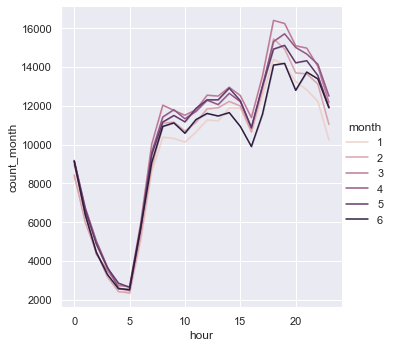

In [24]:
plt.figure(figsize=(30,15))
sns.relplot(data=data, x='hour', y='count_month', hue='month', kind="line")
plt.show()

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, 'id':'store_and_fwd_flag'], data['log_trip_duration'], test_size=0.3, random_state=10)

<Figure size 2160x1080 with 0 Axes>

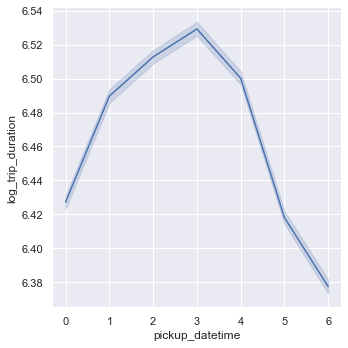

In [26]:
plt.figure(figsize=(30,15))
sns.relplot(x=X_train['pickup_datetime'].apply(datetime.weekday), y=y_train, kind="line")
plt.show()

<Figure size 2160x1080 with 0 Axes>

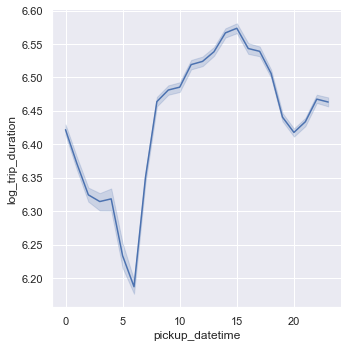

In [27]:
plt.figure(figsize=(30,15))
sns.relplot(x=X_train['pickup_datetime'].apply(lambda x: x.hour), y=y_train, kind="line")
plt.show()

<Figure size 2160x1080 with 0 Axes>

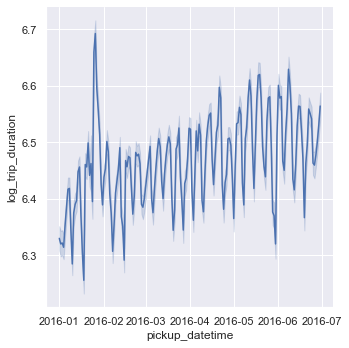

In [28]:
plt.figure(figsize=(30,15))
sns.relplot(x=X_train['pickup_datetime'].apply(datetime.date), y=y_train, kind="line")
plt.show()

In [29]:
a = data.groupby('pickup_date').count()['id'].sort_values().index[0:2]
data[(data['pickup_date'] == a[1]) | (data['pickup_date'] == a[0])].groupby('pickup_date').mean()['log_trip_duration']

pickup_date
2016-01-23    6.456000
2016-01-24    6.395089
Name: log_trip_duration, dtype: float64

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [30]:
X_train['weekday'] = X_train['pickup_datetime'].apply(datetime.weekday)
X_test['weekday'] = X_test['pickup_datetime'].apply(datetime.weekday)

In [31]:
X_train['month'] = X_train['pickup_datetime'].apply(lambda x: x.month)
X_test['month'] = X_test['pickup_datetime'].apply(lambda x: x.month)

In [32]:
X_train['hour'] = X_train['pickup_datetime'].apply(lambda x: x.hour)
X_test['hour'] = X_test['pickup_datetime'].apply(lambda x: x.hour)

In [33]:
X_train['dayofyear'] = X_train['pickup_datetime'].apply(lambda x: x.dayofyear)
X_test['dayofyear'] = X_test['pickup_datetime'].apply(lambda x: x.dayofyear)

In [34]:
a = data.groupby('pickup_date').count()['id'].sort_values().index[0:2]
X_train['anom_1'] = (X_train['pickup_datetime'].apply(datetime.date) == a[0])
X_train['anom_2'] = (X_train['pickup_datetime'].apply(datetime.date) == a[1])
X_test['anom_1'] = (X_test['pickup_datetime'].apply(datetime.date) == a[0])
X_test['anom_2'] = (X_test['pickup_datetime'].apply(datetime.date) == a[1])

In [35]:
X_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekday,month,hour,dayofyear,anom_1,anom_2
824746,id2365163,2,2016-03-27 00:25:29,3,-73.996986,40.742210,-73.987740,40.710659,N,6,3,0,87,False,False
645821,id3126187,2,2016-03-18 20:44:12,1,-73.989929,40.741760,-73.977280,40.783600,N,4,3,20,78,False,False
691846,id2588127,2,2016-04-15 18:26:12,2,-73.972366,40.750725,-73.861832,40.768387,N,4,4,18,106,False,False
1147931,id0915715,2,2016-03-24 14:28:34,1,-73.982361,40.776901,-73.975128,40.760921,N,3,3,14,84,False,False
183569,id3758776,1,2016-04-28 13:53:52,1,-73.973778,40.764374,-73.966957,40.761024,N,3,4,13,119,False,False


**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [36]:
numeric = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', ]
categorical = ['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'weekday', 'month', 'hour', 'dayofyear', 'anom_1', 'anom_2']

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test RMSE = 0.7686341162655401


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [38]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [39]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [40]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [41]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [42]:
X_train.loc[:, 'distance_haversine'] = haversine_array(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values, X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_test.loc[:, 'distance_haversine'] = haversine_array(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values, X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)
data.loc[:, 'distance_haversine'] = haversine_array(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [43]:
X_train['log_haversine'] = np.log1p(X_train['distance_haversine'])
X_test['log_haversine'] = np.log1p(X_test['distance_haversine'])
data['log_haversine'] = np.log1p(data['distance_haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [44]:
data[['log_trip_duration', 'distance_haversine', 'log_haversine']].corr()

,log_trip_duration,distance_haversine,log_haversine
log_trip_duration,1.000000,0.573595,0.749882
distance_haversine,0.573595,1.000000,0.844501
log_haversine,0.749882,0.844501,1.000000


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [45]:
X_train['speed'] = X_train['distance_haversine'] / ((np.exp(y_train) - 1)/3600)
X_test['speed'] = X_test['distance_haversine'] / ((np.exp(y_test) - 1)/3600)

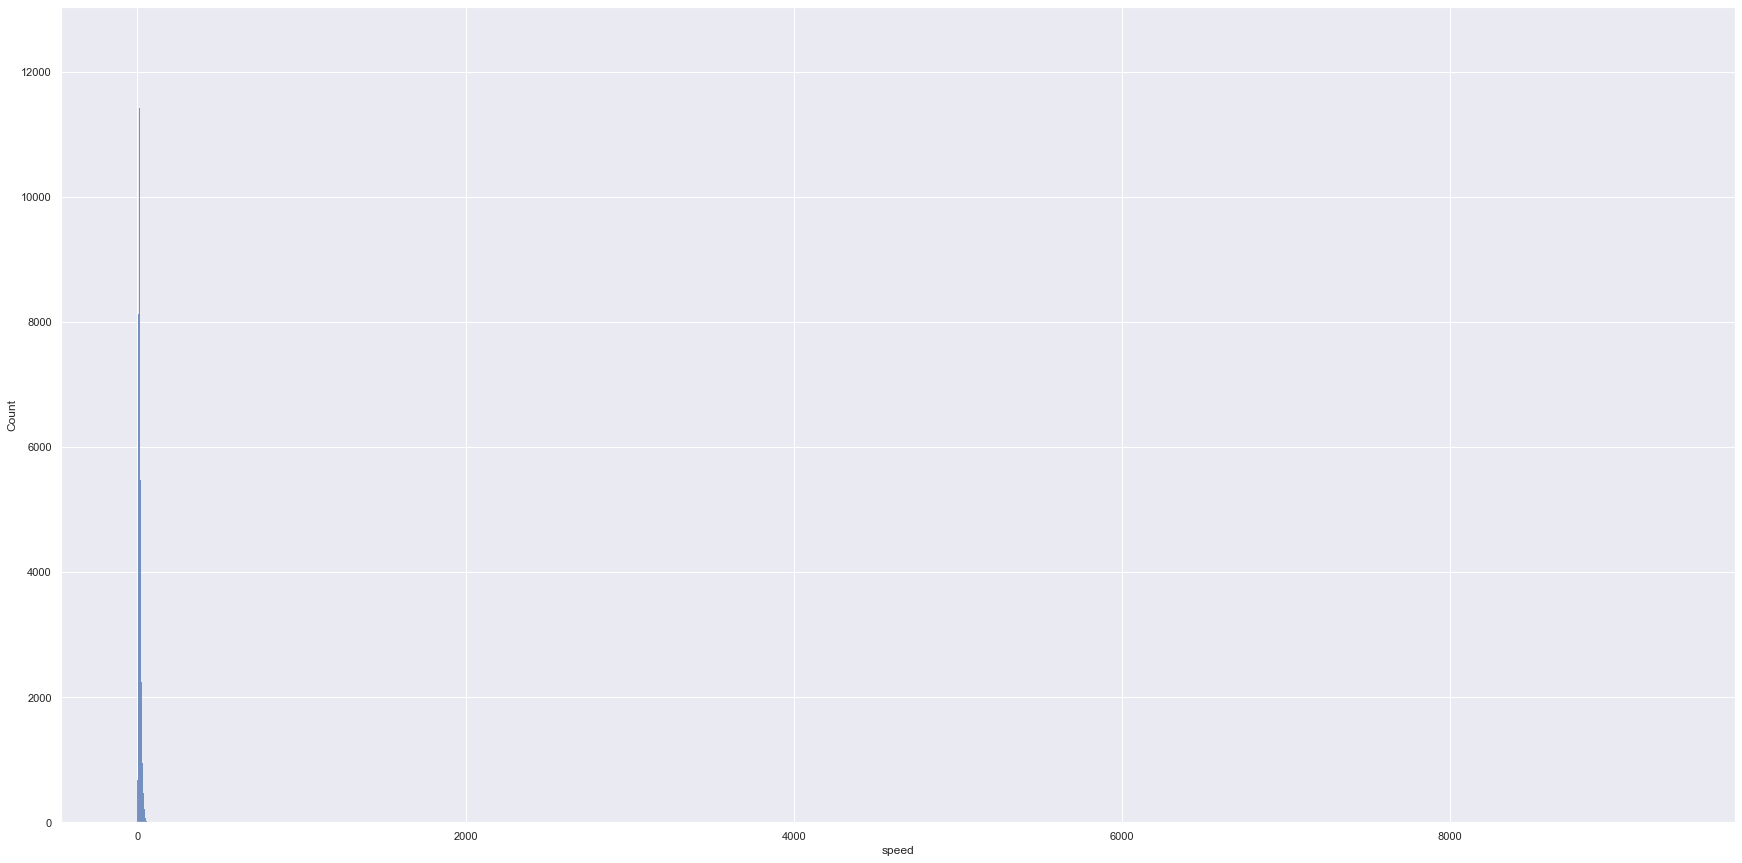

In [46]:
plt.figure(figsize=(30,15))
sns.histplot(X_train['speed'])
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

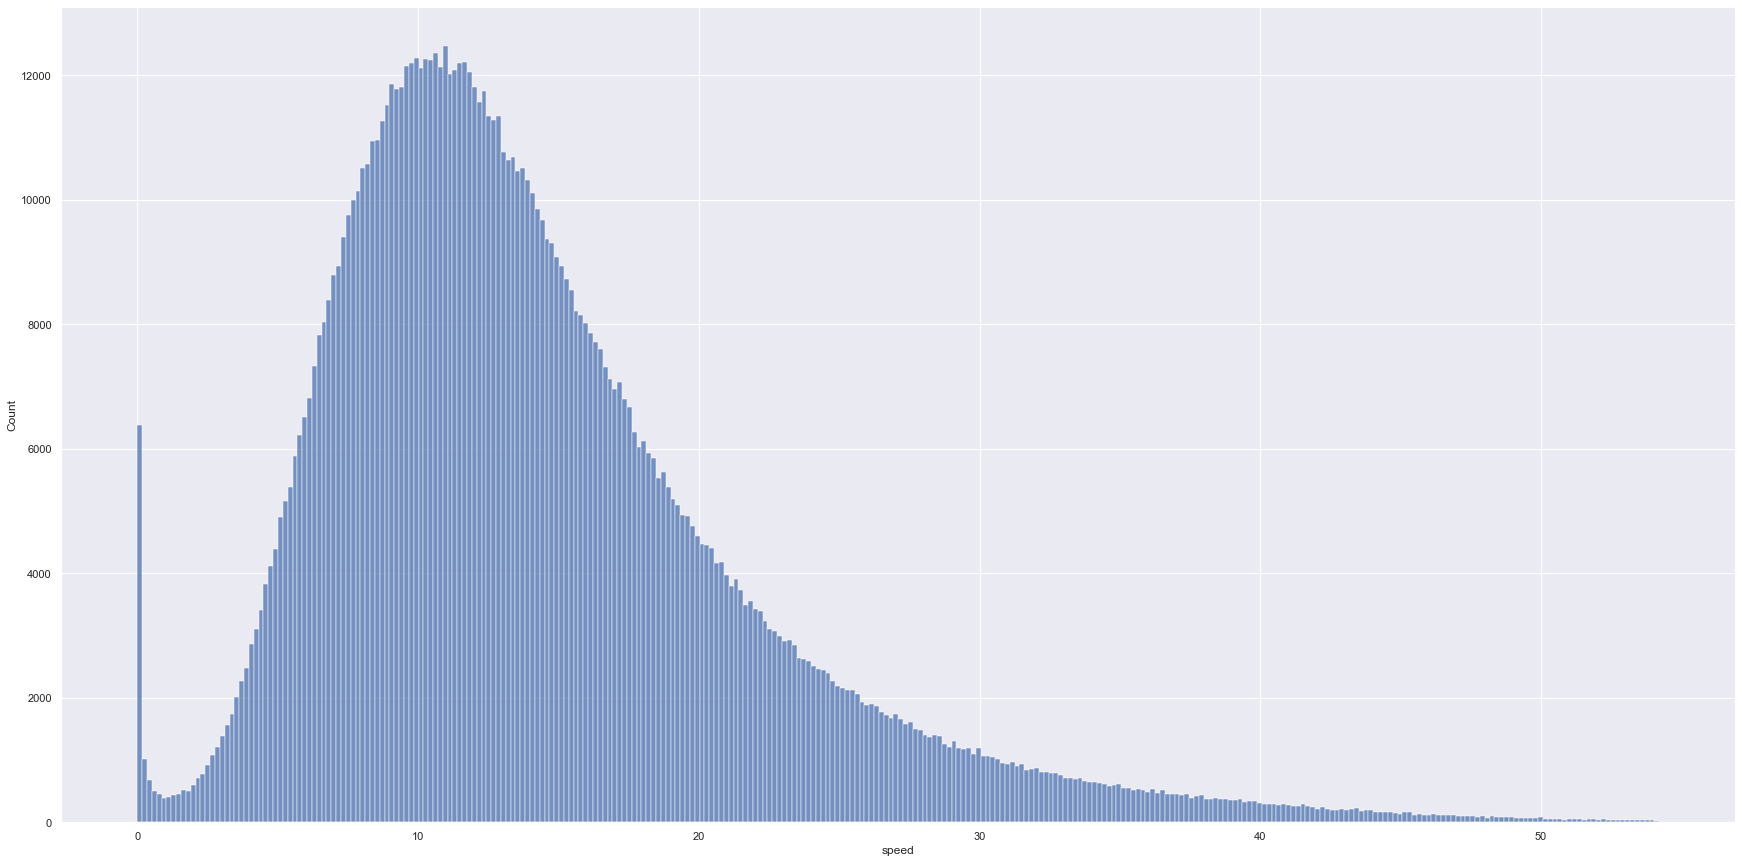

In [47]:
plt.figure(figsize=(30,15))
sns.histplot(X_train['speed'][X_train['speed'] < np.quantile(X_train['speed'], 0.999)])
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [48]:
X_train[X_train['weekday'] == 0].groupby('hour').median()['speed'].values

array([20.33229818, 20.21336545, 20.93636403, 20.68648402, 23.62923236,
       23.69982308, 18.80113811, 14.50783587, 11.56139283, 10.75656341,
       10.90663895, 11.19289719, 11.08945383, 11.47625866, 11.36461773,
       11.50827867, 11.97925689, 11.97884928, 12.16671321, 13.72001478,
       15.32059837, 15.94798285, 16.19577898, 17.76818897])

In [49]:
s = np.array([])
for i in range(0, 7):
    s = np.append(s, X_train[X_train['weekday'] == i].groupby('hour').median()['speed'].values)
s = s.reshape(7, -1)
s

array([[20.33229818, 20.21336545, 20.93636403, 20.68648402, 23.62923236,
        23.69982308, 18.80113811, 14.50783587, 11.56139283, 10.75656341,
        10.90663895, 11.19289719, 11.08945383, 11.47625866, 11.36461773,
        11.50827867, 11.97925689, 11.97884928, 12.16671321, 13.72001478,
        15.32059837, 15.94798285, 16.19577898, 17.76818897],
       [18.76106729, 20.01464404, 20.49521391, 21.35130673, 23.29677217,
        22.95180081, 18.16015617, 13.54885791, 10.44513674,  9.56347156,
         9.41718717,  9.39697047,  9.39930835,  9.79401062,  9.90766818,
        10.00922318, 10.67398451, 10.85944698, 10.99489733, 12.51761559,
        14.07260844, 14.7564386 , 15.56600661, 16.77668692],
       [17.95111034, 19.4935702 , 20.06152974, 20.41106332, 22.69344118,
        22.60271249, 18.27789526, 13.43121763, 10.43865946,  9.54893984,
         9.46856693,  9.10033032,  9.02655765,  9.43884242,  9.59441621,
         9.62239959, 10.47532304, 10.40867526, 10.66074102, 11.79288861,
  

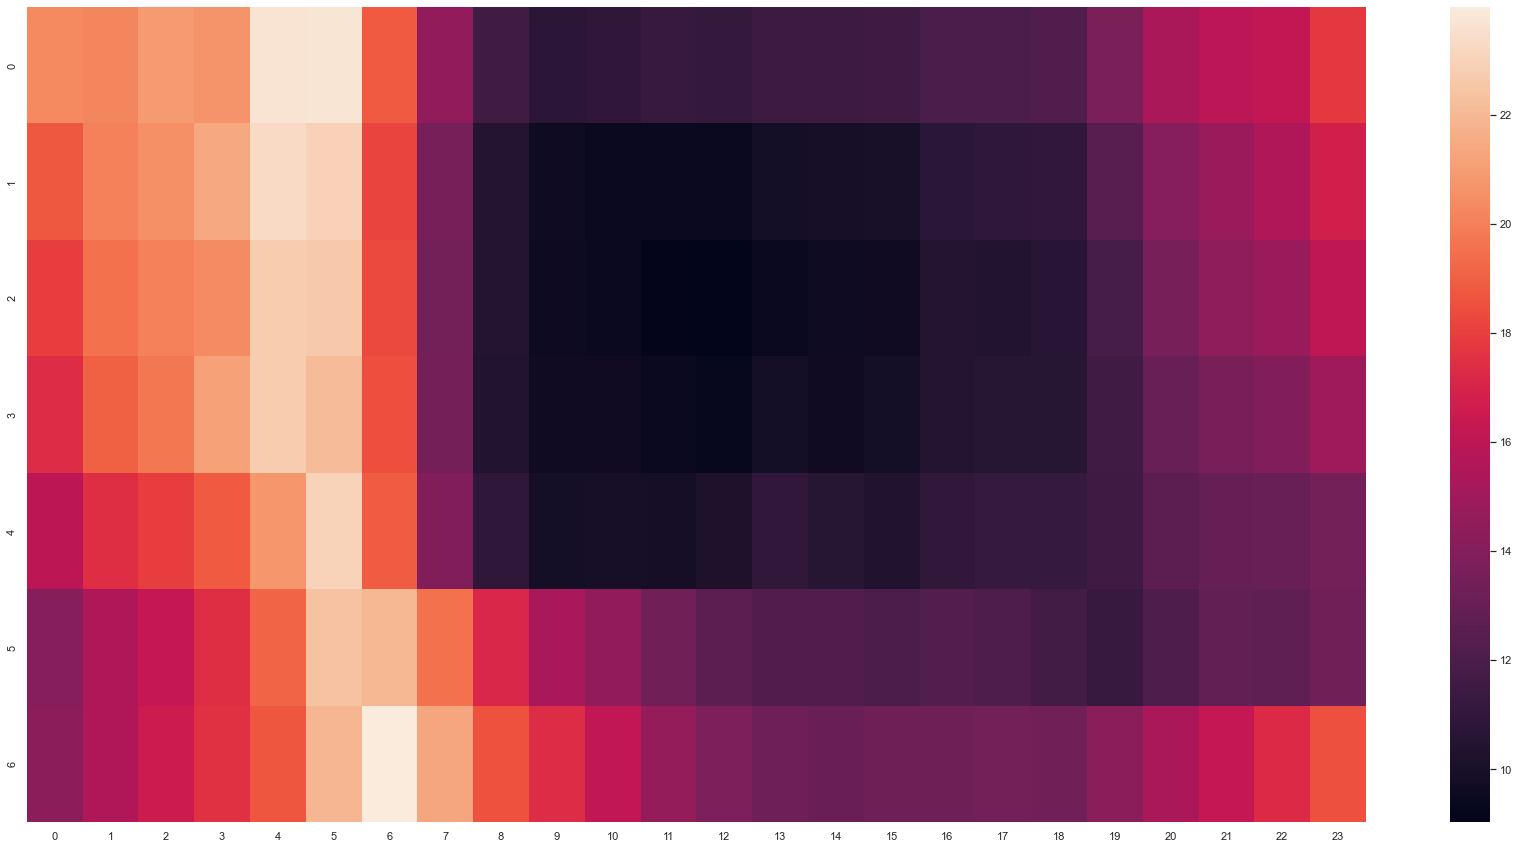

In [50]:
plt.figure(figsize=(30,15))
sns.heatmap(s)
plt.show()

In [51]:
X_train.drop(columns='speed', inplace = True)
X_test.drop(columns='speed', inplace = True)

In [52]:
X_train['probka'] = 0
X_train.loc[X_train.query("(hour == [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] and weekday == [0, 1, 2, 3 ,4]) or (hour == [11, 12, 13, 14, 15, 16, 17, 18, 19] and weekday == [5, 6])").index, 'probka'] = 1
X_train['ne_probka'] = 0
X_train.loc[X_train.query("(hour == [4, 5] and weekday == [0, 1, 2, 3 ,4]) or (hour == [5, 6] and weekday == [5, 6])").index, 'ne_probka'] = 1

X_test['probka'] = 0
X_test.loc[X_test.query("(hour == [10, 11, 12, 13, 14, 15, 16, 17, 18, 19] and weekday == [0, 1, 2, 3 ,4]) or (hour == [11, 12, 13, 14, 15, 16, 17, 18, 19] and weekday == [5, 6])").index, 'probka'] = 1
X_test['ne_probka'] = 0
X_test.loc[X_test.query("(hour == [4, 5] and weekday == [0, 1, 2, 3 ,4]) or (hour == [5, 6] and weekday == [5, 6])").index, 'ne_probka'] = 1

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [53]:
X_train['start_1'] = 0
X_train.loc[X_train.query('-73.88 < pickup_longitude < -73.86 and 40.7675 < pickup_latitude < 40.775').index, 'start_1'] = 1

X_train['stop_1'] = 0
X_train.loc[X_train.query('-73.88 < dropoff_longitude < -73.86 and 40.7675 < dropoff_latitude < 40.775').index, 'stop_1'] = 1

X_train['start_2'] = 0
X_train.loc[X_train.query('-73.795 < pickup_longitude < -73.775 and 40.64 < pickup_latitude < 40.65').index, 'start_2'] = 1

X_train['stop_2'] = 0
X_train.loc[X_train.query('-73.795 < dropoff_longitude < -73.775 and 40.64 < dropoff_latitude < 40.65').index, 'stop_2'] = 1


X_test['start_1'] = 0
X_test.loc[X_test.query('-73.88 < pickup_longitude < -73.86 and 40.7675 < pickup_latitude < 40.775').index, 'start_1'] = 1

X_test['stop_1'] = 0
X_test.loc[X_test.query('-73.88 < dropoff_longitude < -73.86 and 40.7675 < dropoff_latitude < 40.775').index, 'stop_1'] = 1

X_test['start_2'] = 0
X_test.loc[X_test.query('-73.795 < pickup_longitude < -73.775 and 40.64 < pickup_latitude < 40.65').index, 'start_2'] = 1

X_test['stop_2'] = 0
X_test.loc[X_test.query('-73.795 < dropoff_longitude < -73.775 and 40.64 < dropoff_latitude < 40.65').index, 'stop_2'] = 1

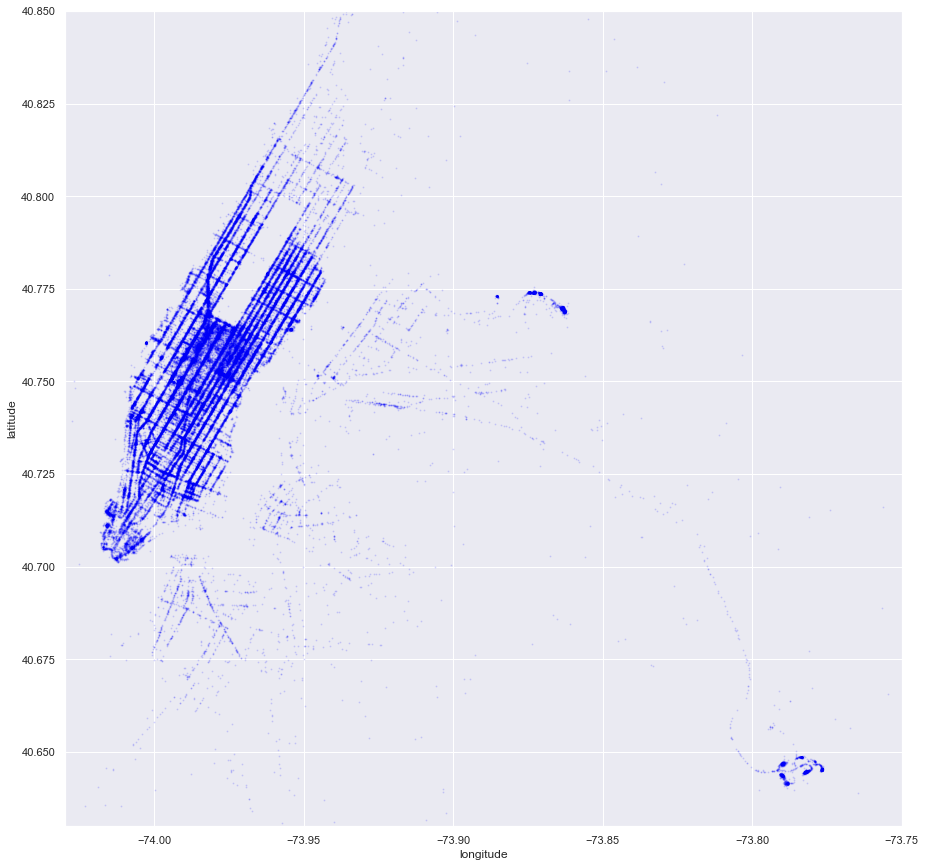

In [54]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(15,15))
plt.scatter(data['pickup_longitude'].values[:N], data['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [55]:
X_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekday,...,anom_1,anom_2,distance_haversine,log_haversine,probka,ne_probka,start_1,stop_1,start_2,stop_2
824746,id2365163,2,2016-03-27 00:25:29,3,-73.996986,40.742210,-73.987740,40.710659,N,6,...,False,False,3.593840,1.524716,0,0,0,0,0,0
645821,id3126187,2,2016-03-18 20:44:12,1,-73.989929,40.741760,-73.977280,40.783600,N,4,...,False,False,4.772773,1.753153,0,0,0,0,0,0
691846,id2588127,2,2016-04-15 18:26:12,2,-73.972366,40.750725,-73.861832,40.768387,N,4,...,False,False,9.514706,2.352775,1,0,0,1,0,0
1147931,id0915715,2,2016-03-24 14:28:34,1,-73.982361,40.776901,-73.975128,40.760921,N,3,...,False,False,1.878364,1.057222,1,0,0,0,0,0
183569,id3758776,1,2016-04-28 13:53:52,1,-73.973778,40.764374,-73.966957,40.761024,N,3,...,False,False,0.684609,0.521533,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348317,id2763967,1,2016-05-12 05:16:06,1,-73.996178,40.748222,-73.990967,40.755478,N,3,...,False,False,0.918456,0.651521,0,1,0,0,0,0
1154171,id0853058,1,2016-01-16 19:14:54,1,-73.995415,40.728886,-73.993706,40.744068,N,5,...,False,False,1.694346,0.991155,1,0,0,0,0,0
617841,id2242904,1,2016-03-21 20:11:12,1,-73.960091,40.779701,-73.960136,40.773102,N,0,...,False,False,0.733833,0.550334,0,0,0,0,0,0
1048548,id2558617,1,2016-04-09 09:21:44,1,-73.968124,40.799923,-73.952415,40.818588,N,5,...,False,False,2.460812,1.241503,0,0,0,0,0,0


<AxesSubplot:xlabel='probka', ylabel='log_trip_duration'>

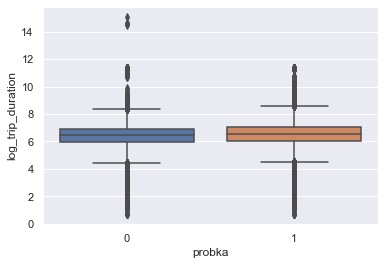

In [56]:
sns.boxplot(x=X_train['probka'], y=y_train)

<AxesSubplot:xlabel='ne_probka', ylabel='log_trip_duration'>

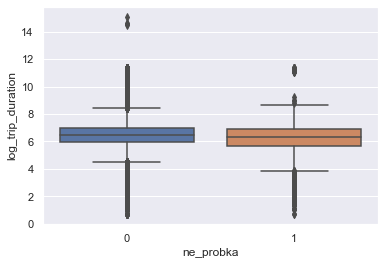

In [57]:
sns.boxplot(x=X_train['ne_probka'], y=y_train)

<AxesSubplot:xlabel='start_1', ylabel='log_trip_duration'>

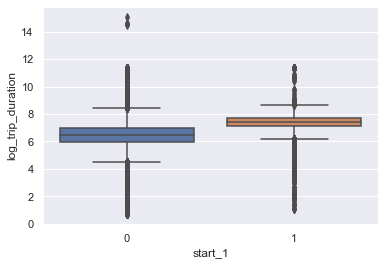

In [58]:
sns.boxplot(x=X_train['start_1'], y=y_train)

<AxesSubplot:xlabel='stop_1', ylabel='log_trip_duration'>

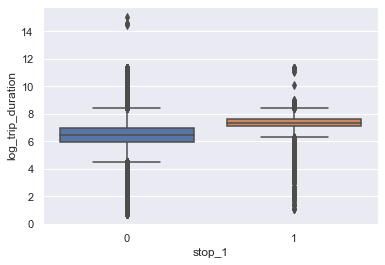

In [59]:
sns.boxplot(x=X_train['stop_1'], y=y_train)

<AxesSubplot:xlabel='start_2', ylabel='log_trip_duration'>

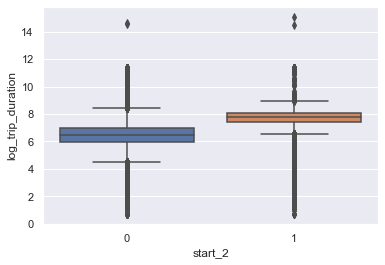

In [60]:
sns.boxplot(x=X_train['start_2'], y=y_train)

<AxesSubplot:xlabel='stop_2', ylabel='log_trip_duration'>

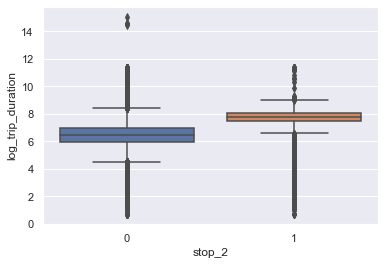

In [61]:
sns.boxplot(x=X_train['stop_2'], y=y_train)

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

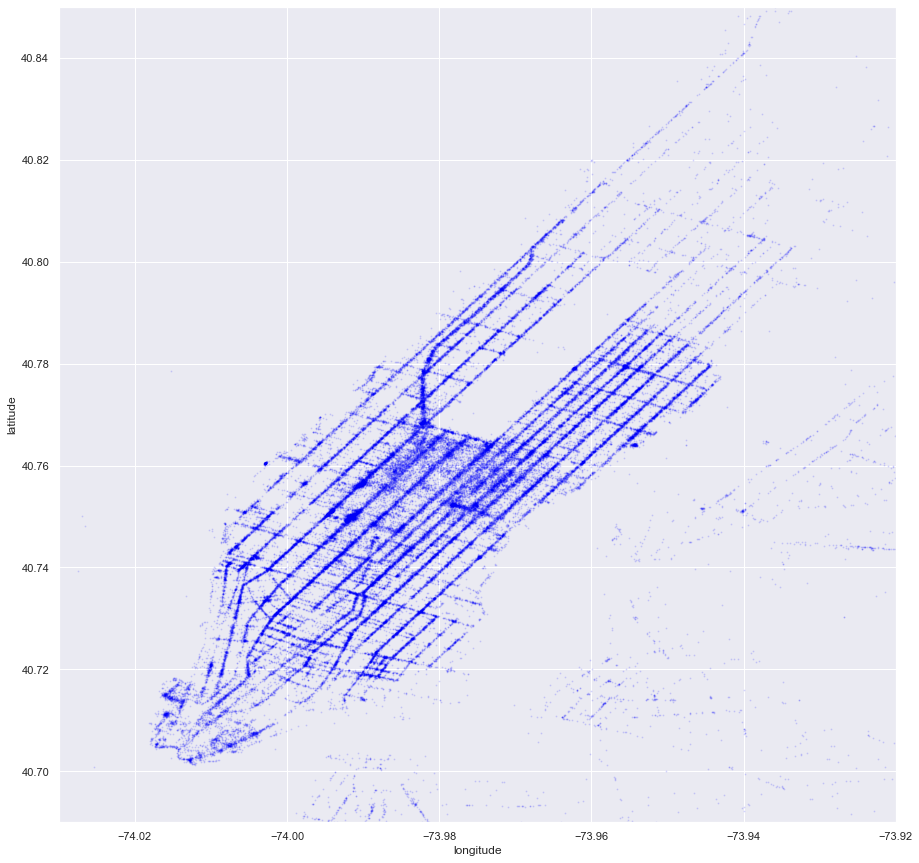

In [62]:
N = 100000
city_long_border = (-74.03, -73.92)
city_lat_border = (40.69, 40.85)
plt.figure(figsize=(15,15))
plt.scatter(data['pickup_longitude'].values[:N], data['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, long1, long2, lat1, lat2, rows=6, cols=4, y = None):
        self.cols = cols
        self.rows = rows
        self.long1 = long1
        self.long2 = long2
        self.lat1 = lat1
        self.lat2 = lat2
        longs = np.linspace(float(self.long1), float(self.long2), self.cols + 1)
        latts = np.linspace(float(self.lat1), float(self.lat2), self.rows + 1)
        cords = np.array([])
        for i in range(len(latts) - 1):
            for j in range(len(longs) - 1):
                cords = np.append(cords, [longs[j], longs[j+1], latts[i], latts[i+1]])
        self.cords = cords.reshape(-1, 4)
        return self
 
    def transform(self, X):
        X = X.copy()
        X['centr_start'] = -1
        X['centr_stop'] = -1
        for i in range(self.rows * self.cols):
            X.loc[X[((self.cords[i][0] < X['pickup_longitude']) &
                     (X['pickup_longitude'] < self.cords[i][1])) &
                    ((self.cords[i][2] < X['pickup_latitude']) &
                     (X['pickup_latitude'] < self.cords[i][3]))].index, 'centr_start'] = i

            X.loc[X[((self.cords[i][0] < X['dropoff_longitude']) &
                     (X['dropoff_longitude'] < self.cords[i][1])) &
                    ((self.cords[i][2] < X['dropoff_latitude']) &
                     (X['dropoff_latitude'] < self.cords[i][3]))].index, 'centr_stop'] = i
        return X

In [64]:
Transformer = MapGridTransformer()
Transformer.fit(X_train, -74.02, -73.94, 40.7, 40.82)
X_train = Transformer.transform(X_train)
X_test = Transformer.transform(X_test)

In [65]:
X_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'weekday', 'month', 'hour',
       'dayofyear', 'anom_1', 'anom_2', 'distance_haversine', 'log_haversine',
       'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 'stop_2',
       'centr_start', 'centr_stop'],
      dtype='object')

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [66]:
numeric = ['log_haversine']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom_1', 'anom_2', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test RMSE = 0.4747611171441548


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [67]:
X_train['vendor_id'].nunique(), X_train['passenger_count'].nunique(), X_train['store_and_fwd_flag'].nunique()

(2, 9, 2)

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<AxesSubplot:xlabel='vendor_id', ylabel='log_trip_duration'>

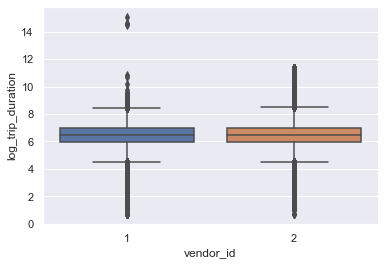

In [68]:
sns.boxplot(x=X_train['vendor_id'], y=y_train)

<AxesSubplot:xlabel='passenger_count', ylabel='log_trip_duration'>

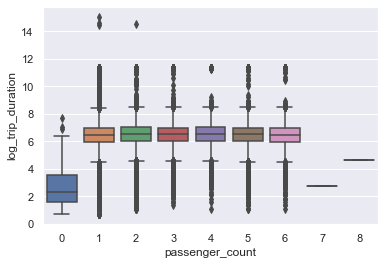

In [69]:
sns.boxplot(x=X_train['passenger_count'], y=y_train)

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='log_trip_duration'>

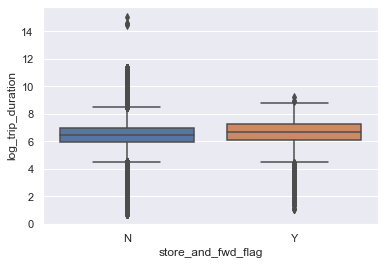

In [70]:
sns.boxplot(x=X_train['store_and_fwd_flag'], y=y_train)

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [71]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE.fit(X_train['vendor_id'])
X_train['vendor_id'] = LE.transform(X_train['vendor_id'])
X_test['vendor_id'] = LE.transform(X_test['vendor_id'])

LE.fit(X_train['store_and_fwd_flag'])
X_train['store_and_fwd_flag'] = LE.transform(X_train['store_and_fwd_flag'])
X_test['store_and_fwd_flag'] = LE.transform(X_test['store_and_fwd_flag'])

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [72]:
numeric = ['log_haversine']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom_1', 'anom_2', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 'passenger_count', 'store_and_fwd_flag']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test RMSE = 0.4744295755164265


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

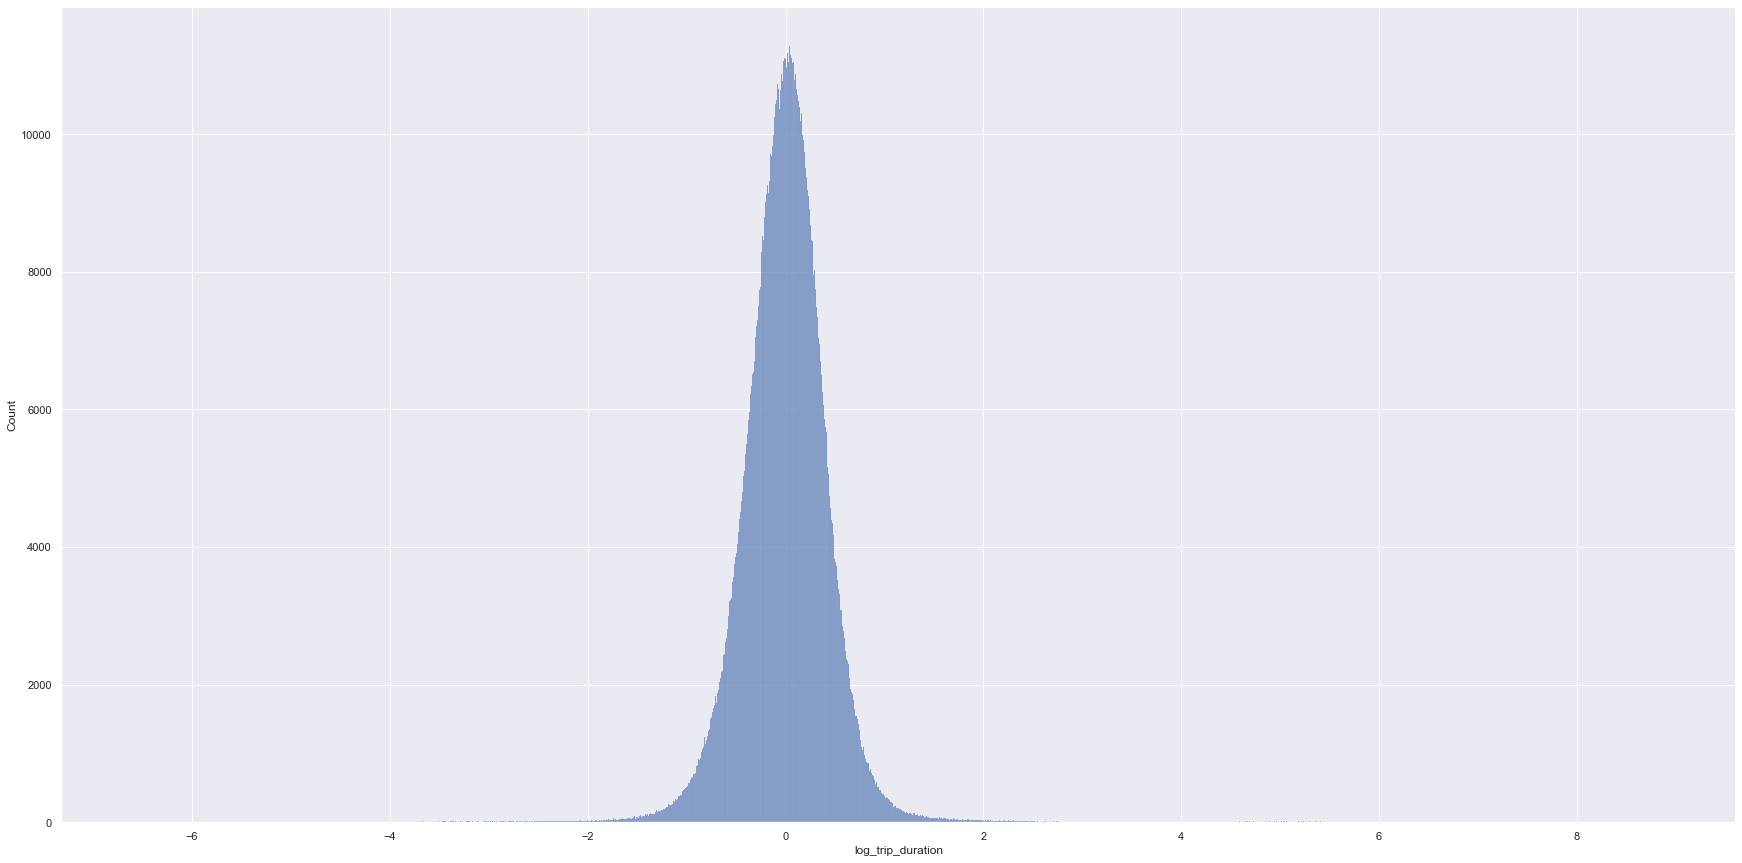

In [73]:
plt.figure(figsize=(30,15))
sns.histplot(y_train - pipeline.predict(X_train))
plt.show()

In [74]:
res = (y_train - pipeline.predict(X_train))

In [75]:
y_train = y_train.loc[((res > res.mean() - 3*res.std()) & (res < res.mean() + 3*res.std())).index]
X_train = X_train.loc[((res > res.mean() - 3*res.std()) & (res < res.mean() + 3*res.std())).index]

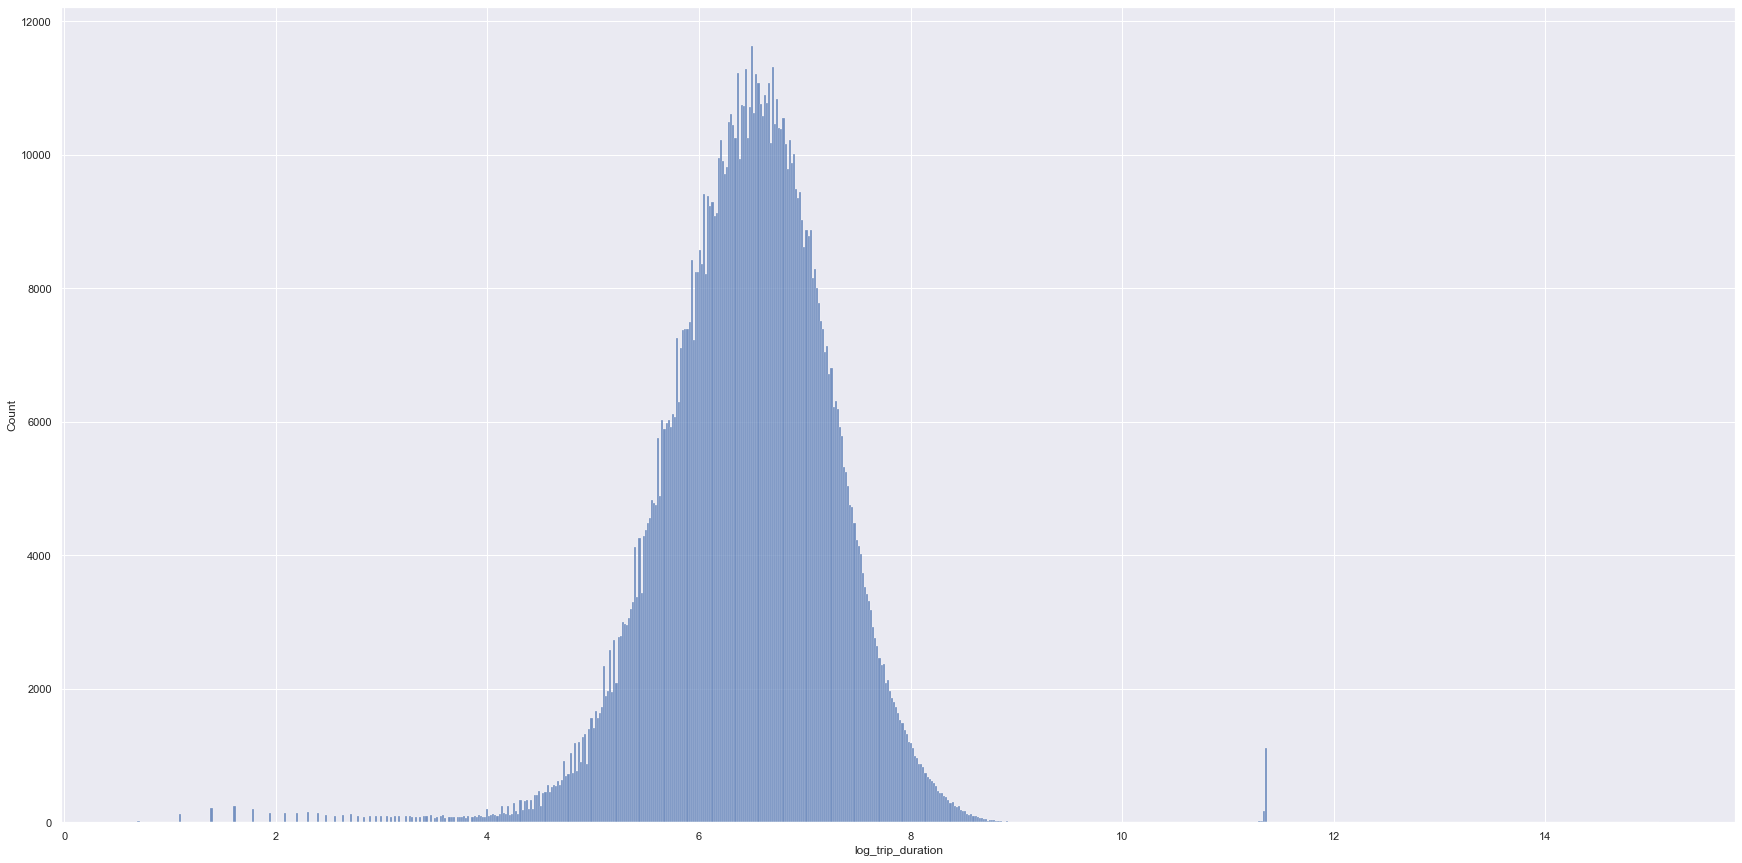

In [76]:
plt.figure(figsize=(30,15))
sns.histplot(y_train)
plt.show()

In [77]:
y_train = y_train[(y_train > y_train.mean() - 3*y_train.std()) & (y_train < y_train.mean() + 3*y_train.std())]
X_train = X_train.loc[y_train.index]

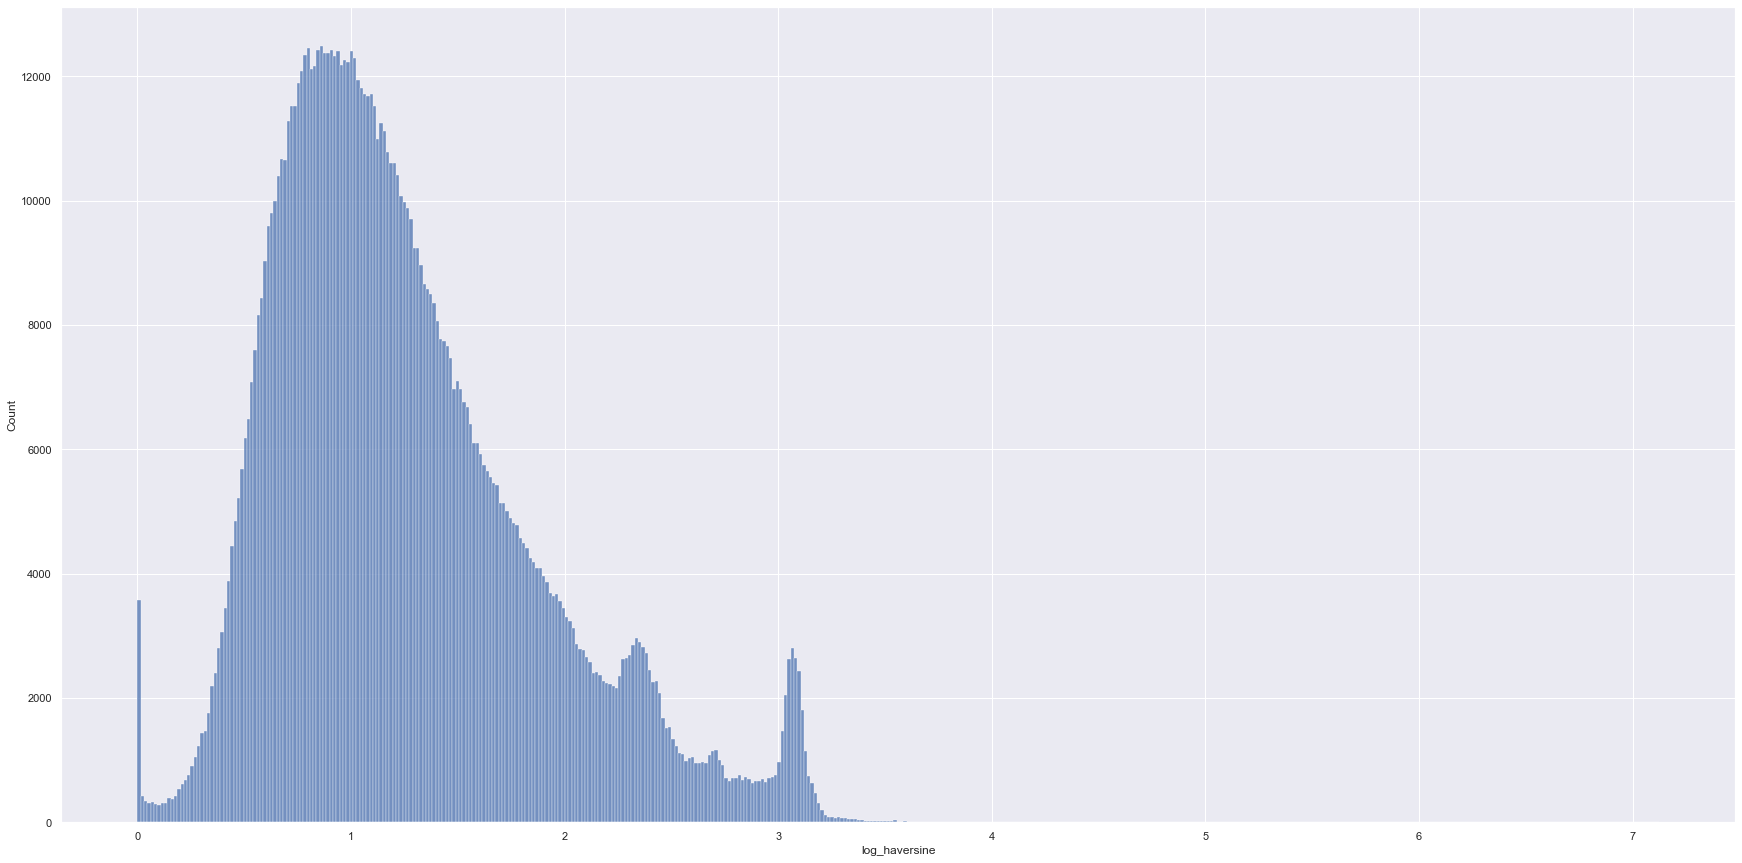

In [78]:
plt.figure(figsize=(30,15))
sns.histplot(X_train["log_haversine"])
plt.show()

In [79]:
np.quantile(X_train["log_haversine"], [0.997, 0.999])

array([3.14650542, 3.24740555])

In [80]:
X_train = X_train[(X_train["log_haversine"] > 0.01) & (X_train["log_haversine"] < 3.6)]
y_train = y_train.loc[X_train.index]

In [81]:
X_train["log_haversine"].mean() - 3*X_train["log_haversine"].std(), X_train["log_haversine"].mean() + 3*X_train["log_haversine"].std()

(-0.5898555836371835, 3.118877316899207)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [82]:
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom_1', 'anom_2', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 'passenger_count', 'store_and_fwd_flag']
X_train[categorical]

,weekday,month,hour,dayofyear,anom_1,anom_2,probka,ne_probka,start_1,stop_1,start_2,stop_2,centr_start,centr_stop,vendor_id,passenger_count,store_and_fwd_flag
824746,6,3,0,87,False,False,0,0,0,0,0,0,9,1,1,3,0
645821,4,3,20,78,False,False,0,0,0,0,0,0,9,18,1,1,0
691846,4,4,18,106,False,False,1,0,0,1,0,0,10,-1,1,2,0
1147931,3,3,14,84,False,False,1,0,0,0,0,0,13,14,1,1,0
183569,3,4,13,119,False,False,1,0,0,0,0,0,14,14,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348317,3,5,5,133,False,False,0,1,0,0,0,0,9,9,0,1,0
1154171,5,1,19,16,False,False,1,0,0,0,0,0,5,9,0,1,0
617841,0,3,20,81,False,False,0,0,0,0,0,0,14,14,0,1,0
1048548,5,4,9,100,False,False,0,0,0,0,0,0,18,23,0,1,0


In [83]:
X_train.groupby('centr_start').count()['id']

centr_start
-1      75437
 0      45467
 1      14157
 2       1460
 3       3006
 4      51447
 5     122893
 6       8684
 7       1078
 8      32365
 9     177862
 10    110164
 11      1913
 12      1682
 13     87549
 14    108270
 15     68476
 17      7104
 18     46439
 19     31004
 22      7239
 23      6341
Name: id, dtype: int64

In [84]:
X_train.loc[X_train.query('centr_start == 3 or centr_start == 7 or centr_start == 11 or centr_start == 12').index, 'centr_start'] = 2

In [85]:
X_train.loc[X_train.query('centr_stop == 7 or centr_stop == 11 or centr_stop == 12 or centr_stop == 16 or centr_stop == 21').index, 'centr_stop'] = 2

In [86]:
X_train['anom'] = X_train['anom_1'] | X_train['anom_2']
X_test['anom'] = X_test['anom_1'] | X_test['anom_2']

In [87]:
X_train.drop(columns=['anom_1', 'anom_1'], inplace=True)
X_test.drop(columns=['anom_1', 'anom_1'], inplace=True)

In [88]:
X_train.loc[X_train.query('passenger_count == 0').index, 'passenger_count'] = 1
X_train.loc[X_train.query('passenger_count == 8').index, 'passenger_count'] = 6

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [180]:
numeric = ['log_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 'passenger_count', 'store_and_fwd_flag']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test RMSE = 0.47417087439914896


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [90]:
print('До преобразования: {0}\nПосле:{1}'.format(len(column_transformer.feature_names_in_), len(column_transformer.get_feature_names_out())))

До преобразования: 25
После:285


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [91]:
from sklearn.linear_model import Lasso

numeric = ['log_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 'passenger_count', 'store_and_fwd_flag']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test RMSE = 0.7943866318084882


Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [181]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
X_train_tr = column_transformer.fit_transform(X_train)
X_test_tr = column_transformer.transform(X_test)

Best alpha = 0.0336


Text(0, 0.5, 'CV score')

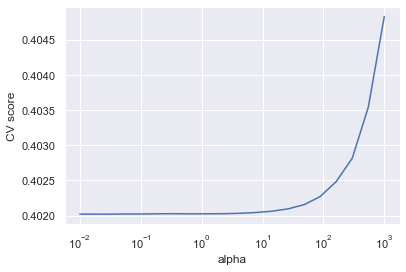

In [182]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher_r = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=5)
searcher_r.fit(X_train_tr, y_train)

best_alpha_r = searcher_r.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_r)

plt.plot(alphas, -searcher_r.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [183]:
min(-searcher_r.cv_results_["mean_test_score"])

0.40202029579450793

Best alpha = 0.0010


Text(0, 0.5, 'CV score')

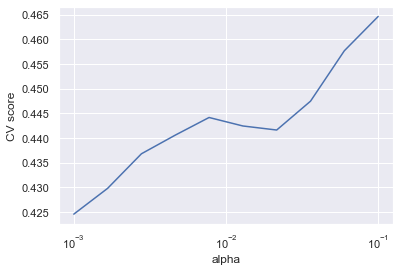

In [95]:
alphas = np.logspace(-3, -1, 10)
searcher_l = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=5)
searcher_l.fit(X_train_tr, y_train)

best_alpha_l = searcher_l.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha_l)

plt.plot(alphas, -searcher_l.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [96]:
min(-searcher_l.cv_results_["mean_test_score"])

0.4245841941731297

In [97]:
numeric = ['log_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 'passenger_count', 'store_and_fwd_flag']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_l))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test Lasso RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test Lasso RMSE = 0.47966820550701916


In [98]:
numeric = ['log_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 'passenger_count', 'store_and_fwd_flag']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_r))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test Ridge RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test Ridge RMSE = 0.47416614436891996


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

Text(0, 0.5, 'Null coefficients')

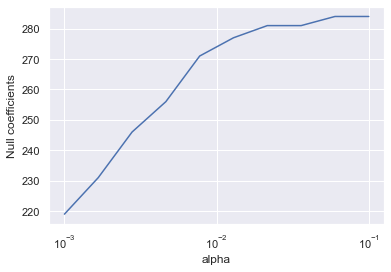

In [99]:
numeric = ['log_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 'passenger_count', 'store_and_fwd_flag']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

alphas = np.logspace(-3, -1, 10)
null_coefs = np.array([])

for i in alphas:
    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Lasso(i))
    ])

    pipeline.fit(X_train, y_train)
    null_coefs = np.append(null_coefs, sum(pipeline.steps[-1][-1].coef_ == 0))

plt.plot(alphas, null_coefs)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Null coefficients")

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.



In [93]:
coup = np.array([])
for i in range(24):
    for j in range(24):
        coup = np.append(coup, [i, j])
coup = coup.reshape(-1, 2)

In [147]:
f = dict([])
f = f.fromkeys(list(map(tuple, coup)))
for i in f:
    f[i] = X_train[(X_train['centr_start'] == i[0]) & (X_train['centr_stop'] == i[1])].shape[0]

In [156]:
sorted_f = {}
sorted_keys = sorted(f, key=f.get)

for w in sorted_keys:
    sorted_f[w] = f[w]

In [177]:
w = list(sorted_f.items())[-100:]
X_train['way'] = -1
for i in range(len(w)):
    X_train.loc[X_train[(X_train['centr_start'] == w[i][0][0]) & (X_train['centr_stop'] == w[i][0][1])].index, 'way'] = i

X_test['way'] = -1
for i in range(len(w)):
    X_test.loc[X_test[(X_test['centr_start'] == w[i][0][0]) & (X_test['centr_stop'] == w[i][0][1])].index, 'way'] = i

In [178]:
X_test

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekday,...,probka,ne_probka,start_1,stop_1,start_2,stop_2,centr_start,centr_stop,anom,way
112342,id2631171,1,2016-01-23 00:09:14,1,-74.006615,40.731712,-73.991890,40.727161,0,5,...,0,0,0,0,0,0,4,5,True,78
840803,id2892416,0,2016-02-10 19:24:14,3,-73.963203,40.777924,-74.004059,40.747654,0,2,...,1,0,0,0,0,0,14,8,False,-1
184538,id3095142,1,2016-05-12 06:39:26,1,-73.987595,40.719822,-74.010994,40.716148,0,3,...,0,0,0,0,0,0,1,0,False,-1
512001,id3803823,1,2016-01-21 08:31:03,1,-73.969055,40.763618,-73.974129,40.778679,0,3,...,0,0,0,0,0,0,14,14,False,93
776055,id3155730,1,2016-01-02 13:12:33,2,-73.950165,40.775635,-73.944534,40.779636,0,5,...,1,0,0,0,0,0,15,15,False,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846197,id1951185,0,2016-01-09 23:00:55,4,-74.005753,40.739868,-73.997940,40.725216,0,5,...,0,0,0,0,0,0,4,5,False,78
85559,id1088375,1,2016-06-02 15:06:24,1,-73.970680,40.783981,-73.952904,40.780006,0,3,...,1,0,0,0,0,0,18,19,False,32
940126,id1422099,0,2016-05-02 09:51:23,1,-73.998932,40.734386,-73.991318,40.745682,0,0,...,0,0,0,0,0,0,5,9,False,95
643278,id2188597,1,2016-04-06 09:28:59,1,-73.957962,40.776279,-73.991577,40.750111,0,2,...,0,0,0,0,0,0,15,9,False,49


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [184]:
numeric = ['log_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 
               'passenger_count', 'store_and_fwd_flag', 'way']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_r))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test Ridge RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test Ridge RMSE = 0.463991627880356


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [188]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [194]:
X_train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values, X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values, X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)
data.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(data['pickup_latitude'].values, data['pickup_longitude'].values, data['dropoff_latitude'].values, data['dropoff_longitude'].values)

In [195]:
X_train['log_manhattan'] = np.log1p(X_train['distance_dummy_manhattan'])
X_test['log_manhattan'] = np.log1p(X_test['distance_dummy_manhattan'])
data['log_manhattan'] = np.log1p(data['distance_dummy_manhattan'])

In [196]:
data[['log_trip_duration', 'log_manhattan', 'log_haversine']].corr()

,log_trip_duration,log_manhattan,log_haversine
log_trip_duration,1.000000,0.744762,0.749882
log_manhattan,0.744762,1.000000,0.994539
log_haversine,0.749882,0.994539,1.000000


In [192]:
X_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,weekday,...,start_1,stop_1,start_2,stop_2,centr_start,centr_stop,anom,way,distance_dummy_manhattan,log_manhattan
824746,id2365163,1,2016-03-27 00:25:29,3,-73.996986,40.742210,-73.987740,40.710659,0,6,...,0,0,0,0,9,1,False,-1,4.287371,1.665321
645821,id3126187,1,2016-03-18 20:44:12,1,-73.989929,40.741760,-73.977280,40.783600,0,4,...,0,0,0,0,9,18,False,35,5.718047,1.904797
691846,id2588127,1,2016-04-15 18:26:12,2,-73.972366,40.750725,-73.861832,40.768387,0,4,...,0,1,0,0,10,-1,False,-1,11.274979,2.507563
1147931,id0915715,1,2016-03-24 14:28:34,1,-73.982361,40.776901,-73.975128,40.760921,0,3,...,0,0,0,0,13,14,False,77,2.385883,1.219615
183569,id3758776,0,2016-04-28 13:53:52,1,-73.973778,40.764374,-73.966957,40.761024,0,3,...,0,0,0,0,14,14,False,93,0.946858,0.666217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348317,id2763967,0,2016-05-12 05:16:06,1,-73.996178,40.748222,-73.990967,40.755478,0,3,...,0,0,0,0,9,9,False,99,1.245743,0.809036
1154171,id0853058,0,2016-01-16 19:14:54,1,-73.995415,40.728886,-73.993706,40.744068,0,5,...,0,0,0,0,5,9,False,95,1.832223,1.041062
617841,id2242904,0,2016-03-21 20:11:12,1,-73.960091,40.779701,-73.960136,40.773102,0,0,...,0,0,0,0,14,14,False,93,0.737677,0.552549
1048548,id2558617,0,2016-04-09 09:21:44,1,-73.968124,40.799923,-73.952415,40.818588,0,5,...,0,0,0,0,18,23,False,4,3.397773,1.481098


Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [197]:
numeric = ['log_haversine', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'log_manhattan']
categorical = ['weekday', 'month', 'hour', 'dayofyear', 'anom', 
               'probka', 'ne_probka', 'start_1', 'stop_1', 'start_2', 
               'stop_2', 'centr_start', 'centr_stop', 'vendor_id', 
               'passenger_count', 'store_and_fwd_flag', 'way']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])
    
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_r))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Test Ridge RMSE = {}".format(mean_squared_error(y_test, y_pred, squared=False)))

Test Ridge RMSE = 0.463280289429019
